### Model inspired by:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] Modelling and Control of Offshore Marine Pipeline during Pipelay. Gullik A. Jensen et al

#### Motion equation used:
M(q)q ̈ + C(q,q ̇)q ̇ + H(q,q ̇)q ̇ + f(q) + g(q) = τ

In [1]:
import numpy as np
import math
from scipy.integrate import odeint, ode, solve_ivp
from scipy.integrate import ode
from scipy.misc import derivative
from numpy.linalg import inv, pinv
import numdifftools as nd
import tqdm
import functools
from datetime import datetime
from scipy.optimize import fsolve
from scipy.linalg import lu_factor, lu_solve

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

### Modelling data:

In [4]:
N = 12  # Number of simulation nodes

In [5]:
pipe_weight_per_unit_length = 96 #  (submerged) [kg/m]  # 113.07 - not submerged

In [6]:
h = 700 # water depth, [m]

In [7]:
dq = np.zeros(N) #  these numbers are used for in itial checks only and redefined below

In [8]:
# Catenary

In [9]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]

In [10]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [11]:
Fx_0 = 82945396
Fx_ = 7.5e7 # [N], from the Jensen thesis

In [12]:
S = math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [13]:
delta_x = horizontal_length/N

In [14]:
x0 = [i*delta_x for i in range(N+1)]
y0 = []
for i in range(len(x0)):
    y0.append(catenary(x0[i],Ws,Fx_))

In [15]:
q=[]
l=[]
deg_=[0]

for i in range(len(x0)-1):
    l.append(np.sqrt((x0[i+1]-x0[i])**2+(y0[i+1]-y0[i])**2))
    deg =np.degrees(math.atan((y0[i+1]-y0[i])/(x0[i+1]-x0[i])))
    q.append(deg-deg_[-1]) 
    deg_.append(deg)

In [16]:
l

[921.072470829933,
 921.1956775848867,
 921.4421075747438,
 921.8117937616091,
 922.3047855941514,
 922.9211490142245,
 923.6609664656845,
 924.5243369054327,
 925.5113758166391,
 926.6222152242184,
 927.8570037124688,
 929.2159064449938]

In [17]:
pipe_joint_length = l[0]  # [m]
mn = 32219000 # mass of the vessel, [kg]

In [18]:
# L - the hull length
# Xg - x-center of gravity

L = 169 # [m]
Xg = 78 # [m]

In [19]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [20]:
In = vessel_inertia_moment(mn,Xg,L)

In [21]:
In

253533324687.5

In [22]:
mi = [x*pipe_weight_per_unit_length for x in l] # mass of pipe element (submerged), [kg]

In [23]:
# for hydrodynamic damping matrix
Cd=[0.87 for x in range(N)] # Drag coefficient
Cd[-1] = 1.6 

In [24]:
# Pipe
qw = 1025 # Water density [kg/m3]
d0 = 0.7610 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [25]:
# for vector of spring forces in the pipe joints
E = 210e9 # modulus of elasticity of steel, [N/m^2]
EI = E*3.14/64*(d0**4-dI**4) # Bending stiffness [N*m^2]

C0=3
K = C0*EI/pipe_joint_length**3 # depends on the unit bending stiffness of the pipe (EI), 
                               # and the length li, of the link; from the Jensen thesis [N/m]

In [26]:
K

4.300094536553864

In [27]:
# for vector of control inputs
tau_qn = 250576 # tension in pipe at water level, [N] (check catenary calculation sheets)

In [28]:
# Time integration params:
max_t = 600 
dt = 0.5
t=np.arange(0,max_t,dt)
DP_start=100

In [29]:
Awp = 1000 # the waterplane area of the vessel, [m^2]
fip=1e12

In [30]:
kp=2.95e4
kd=2.5e4

### System inertia matrix 

In [31]:
def alpha(q):
    sum_=0
    ans=[]
    for i in range(len(q)):
        sum_+=q[i]
        ans.append(sum_)
    return np.array(ans)

In [32]:
def Jv(q, i, l):
    alp=alpha(q)
    def Jv0(i, k, alp, l):
        
        if k<i:
            tmp1=np.dot(np.array(l[k:i]),np.sin(np.radians(alp[k:i])))
            tmp1=-tmp1-0.5*l[i]*np.sin(np.radians(alp[i]))
            
            tmp2 =np.dot(np.array(l[k:i]),np.cos(np.radians(alp[k:i])))
            tmp2=tmp2+0.5*l[i]*np.cos(np.radians(alp[i]))
                        
            return np.array([tmp1, tmp2]).T
        elif k==i:
            return np.array([-0.5*l[i]*np.sin(np.radians(alp[i])),
                    0.5*l[i]*np.cos(np.radians(alp[i]))]).T
        else:
            return np.array([0, 0]).T                 
    
    ans=np.array([Jv0(i, k, alp, l) for k in range(len(q))])
    
    return ans.T

In [33]:
Jv(q, 2, l)

array([[ -34.62354568,  -29.29722999,  -13.31757044,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ],
       [2302.64267593, 1381.58560556,  460.52853519,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ]])

In [34]:
def Jomega(i,q):

    def Jomega0(i,k):
        if k<=i:
            return 1
        return 0
    ans=np.array([Jomega0(i, k) for k in range(len(q))])
   
    return ans.reshape(len(q),1).T

In [35]:
def M(q, l, mn, In, mi):
  
    
    sum1 = mn * np.dot(Jv( q, len(q)-1, l).T, Jv(q, len(q)-1, l))
    
 
    sum2 = In * np.dot(Jomega(len(q)-1,q).T, Jomega(len(q)-1,q))
    
    sum3=0
    
    for i in range(len(q)-1):
        J_v = Jv(q, i, l)
        sum3+=mi[i]*np.dot(J_v.T, J_v)
      
    return sum1 + sum2 + sum3   

In [36]:
M(q, l, mn, In, mi)

array([[3.66457301e+15, 3.34558489e+15, 3.02642695e+15, 2.70717426e+15,
        2.38790198e+15, 2.06868545e+15, 1.74960025e+15, 1.43072230e+15,
        1.11212791e+15, 7.93893825e+14, 4.76097365e+14, 1.58816438e+14],
       [3.34558489e+15, 3.05470166e+15, 2.76359424e+15, 2.47231888e+15,
        2.18095074e+15, 1.88956509e+15, 1.59823748e+15, 1.30704375e+15,
        1.01606013e+15, 7.25363300e+14, 4.35030475e+14, 1.45139463e+14],
       [3.02642695e+15, 2.76359424e+15, 2.50052418e+15, 2.23723553e+15,
        1.97378458e+15, 1.71024658e+15, 1.44669698e+15, 1.18321155e+15,
        9.19866427e+14, 6.56738198e+14, 3.93903959e+14, 1.31441403e+14],
       [2.70717426e+15, 2.47231888e+15, 2.23723553e+15, 2.00192415e+15,
        1.76640347e+15, 1.53072987e+15, 1.29497871e+15, 1.05922567e+15,
        8.23546782e+14, 5.88018501e+14, 3.52717806e+14, 1.17722251e+14],
       [2.38790198e+15, 2.18095074e+15, 1.97378458e+15, 1.76640347e+15,
        1.55880733e+15, 1.35101489e+15, 1.14308263e+15, 9.35

### Coriolis-centripetal matrix

In [37]:
def C(q, dq, l, mn, In, mi): 
    ans = np.zeros((len(q),len(q)))              
    fun = lambda q: M(q, l, mn, In, mi)
    Dfun = nd.Gradient(fun) 
    
    diff = Dfun(q)

    
    def c(i,j,k):
        return 0.5 *(diff[k].item((i,j))+
                     diff[j].item((i,k))-
                     diff[i].item((j,k)))
    
    for i in range(len(q)):
        for j in range(len(q)):
            for k in range(len(q)):
                ans[i][j]+=c(i,j,k)*np.radians(dq[k])
    return ans    

In [38]:
C(q, dq, l, mn, In, mi)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Hydrodynamic damping matrix

In [39]:
def R_I_Bi(i, alp):
    return np.array([[np.cos(np.radians(alp[i])), -np.sin(np.radians(alp[i]))],
                    [np.sin(np.radians(alp[i])), np.cos(np.radians(alp[i]))]])

In [40]:
alp=alpha(q)

In [41]:
R_I_Bi(2, alp)

array([[ 0.99958214, -0.02890593],
       [ 0.02890593,  0.99958214]])

In [42]:
I_=np.array([[0,0],
             [0,1]])

In [43]:
def Pi(i,alp):
    return np.dot(np.dot(R_I_Bi(i, alp),I_),R_I_Bi(i, alp).T)

In [44]:
def mod_Vn(q, alp, dq):
    ans=[]
    for j in range(len(q)):
        ans.append(np.dot(np.dot(Pi(j,alp),Jv( q,j, l)), np.radians(dq)))
    return np.linalg.norm(np.array(ans))

In [45]:
mod_Vn(q,alp,dq)

0.0

In [46]:
def mod_Vni(i,q,alp,dq):
    return np.linalg.norm(np.dot(np.dot(Pi(i,alp),Jv( q,i, l)), np.radians(dq)))

In [47]:
mod_Vni(len(q)-1,q,alp,dq)

0.0

In [48]:
def gamma(i):
    return 0.5*Cd[i]*qw*d0*l[i]

In [49]:
def H(alp,q,dq,l):
    ans=np.zeros((len(q), len(q)))
    alp=alpha(q)
    for j in range(len(q)):
        ans+=gamma(j)*mod_Vni(j,q,alp,dq)*np.dot(np.dot(Jv(q,j,l).T,Pi(j,alp)),Jv( q,j, l))
    return ans    

In [50]:
alp

array([0.33132801, 0.99393972, 1.65641851, 2.31867586, 2.98062341,
       3.642173  , 4.30323674, 4.96372705, 5.62355675, 6.28263907,
       6.94088777, 7.59821713])

In [51]:
H(alp,q,dq,l)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Vector of spring forces in the pipe joints

In [52]:
def f(q,k):
    ans=np.array([k*q[i] for i in range(len(q))])
    return ans.reshape(len(q),1)

### Vector of gravitational/buoyancy forces

In [53]:
def x(alp,i,l):
    tmp1=np.dot(np.array(l[:i]),np.cos(np.radians(alp[:i])))

    tmp1+=0.5*l[i]*np.cos(np.radians(alp[i]))
    return tmp1

In [54]:
x(alp,2,l)

2302.6426759295045

In [55]:
def y(alp,i,l):
    tmp1=np.dot(np.array(l[:i]),np.sin(np.radians(alp[:i])))
    tmp1+=0.5*l[i]*np.sin(np.radians(alp[i]))
    return tmp1

In [56]:
y(alp,2,l)

34.62354568140978

In [57]:
G=np.array([0,-9.81]).T

def ggi(i,G):
    return mi[i]*G
   
    
def gbi(G,l,i):
    return -3.14*l[i]*(d0**2/4)*qw*G 


def gt(alp,fip, i): 
    return -fip*np.radians(alp[i]) # not complete formula


In [58]:
def g(q,alp):
    sum_=0
    for i in range(len(q)-1):
        sum_+=np.dot(Jv( q,i, l).T,ggi(i,G)+gbi(G,l,i))
    tmp = -qw*Awp*(y(alp,len(alp)-1,l)-h)*G 
    sum_ += np.dot(Jv(q,len(q)-1, l).T, tmp)  #- \
    return sum_.reshape(len(q),1)   

In [59]:
g(q,alp)

array([[9.09124511e+11],
       [8.13912844e+11],
       [7.21780470e+11],
       [6.32728006e+11],
       [5.46756484e+11],
       [4.63867345e+11],
       [3.84062442e+11],
       [3.07344044e+11],
       [2.33714829e+11],
       [1.63177891e+11],
       [9.57367355e+10],
       [3.13952839e+10]])

### Vector of control inputs

In [60]:
# Assume that the stinger is shorter than the link length li for any link i
def tau_q(q,tau_qn): 
    ans= np.array([0 for i in range(len(q))]).reshape(len(q),1)
    ans[-1] = tau_qn
    return ans

In [61]:
def Fx(q,alp,dq,kp, kd, x_ref = 0):
    return -kp*(x(alp,len(q)-1,l)-x_ref) - kd*mod_Vn(q,alp,dq)

In [62]:
Fx(q,alp,dq,kp, kd, x_ref = 0)

-312468611.12363374

In [63]:
F1=np.array([Fx_,0]).reshape(2,1) # actuates the vessel in the surge direction in frame Bn
def tau_t(q, F):
    tmp= np.dot(Jv(q,len(q)-1, l).T, F)
    return tmp

In [64]:
tau_t(q, F1)

array([[-5.30084828e+10],
       [-5.26090091e+10],
       [-5.14105346e+10],
       [-4.94128991e+10],
       [-4.66158352e+10],
       [-4.30189689e+10],
       [-3.86218190e+10],
       [-3.34237973e+10],
       [-2.74242086e+10],
       [-2.06222503e+10],
       [-1.30170125e+10],
       [-4.60747804e+09]])

In [65]:
y(alp,0,l),y(alp,len(q)-1,l)

(2.6631578469722688, 706.7797705643477)

In [66]:
tau_q_wave=9e6 # (taken from article on forces to semi-submersible platform),[N]
def tau_wave(q, alp, tau_q_wave): 
    A0 = tau_q_wave         
    k = 0.5          
    ans=[]
    for i in range(len(q)):
        ans.append([tau_q_wave * np.exp(-k * (y(alp,len(q)-1,l)-y(alp,i,l)))  ])   
    return np.array(ans)

In [67]:
def tau(q, alp, tau_qn, F, tau_q_wave):
    return tau_t(q, F) + tau_wave(q, alp, tau_q_wave)

In [68]:
tau_wave(q,alp, tau_q_wave)

array([[1.14093985e-146],
       [2.34708933e-144],
       [9.93968881e-140],
       [8.67783035e-133],
       [1.56521203e-123],
       [5.84920687e-112],
       [4.54496504e-098],
       [7.37448840e-082],
       [2.51113093e-063],
       [1.80476991e-042],
       [2.75536528e-019],
       [9.00000000e+006]])

In [69]:
tau(q, alp, tau_qn, F1, tau_q_wave)

array([[-5.30084828e+10],
       [-5.26090091e+10],
       [-5.14105346e+10],
       [-4.94128991e+10],
       [-4.66158352e+10],
       [-4.30189689e+10],
       [-3.86218190e+10],
       [-3.34237973e+10],
       [-2.74242086e+10],
       [-2.06222503e+10],
       [-1.30170125e+10],
       [-4.59847804e+09]])

### Static solution

In [70]:
alp_=alpha(q)

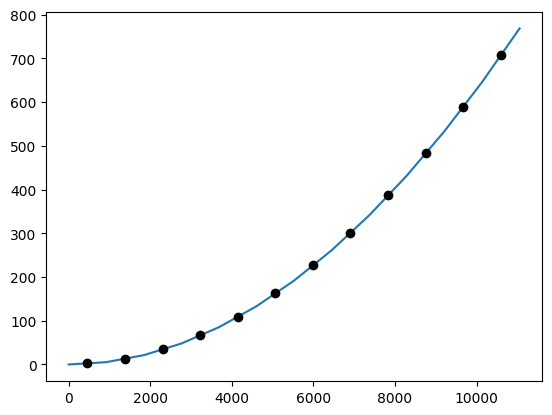

In [71]:
plt.plot(x0, y0)
for i in range(len(q)):
    plt.plot(x(alp_,i,l),y(alp_,i,l), 'o', color='black')
plt.show()

In [72]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    q0.append(0)

In [73]:
dq

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [74]:
F_=np.array([-Fx(q,alp_,dq,kp, 0, x_ref = 0),0]).reshape(2,1)

In [75]:
def static_func(q):
    alp=alpha(q)
    ans=  f(q, K) + g(q,alp) - tau(q,alp, tau_qn, F_, 0)
    return ans.reshape((len(q),))

In [76]:
root = fsolve(static_func, np.array(q))

In [77]:
root

array([0.54806383, 0.61288642, 0.61274371, 0.61254281, 0.61228381,
       0.61196681, 0.61159192, 0.61115928, 0.61066904, 0.61012137,
       0.60951644, 0.30440215])

In [78]:
q = list(root)

In [79]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    q0.append(0)

In [80]:
alp_=alpha(root)

In [81]:
alp_

array([0.54806383, 1.16095025, 1.77369396, 2.38623678, 2.99852059,
       3.61048739, 4.22207931, 4.83323859, 5.44390764, 6.054029  ,
       6.66354544, 6.96794759])

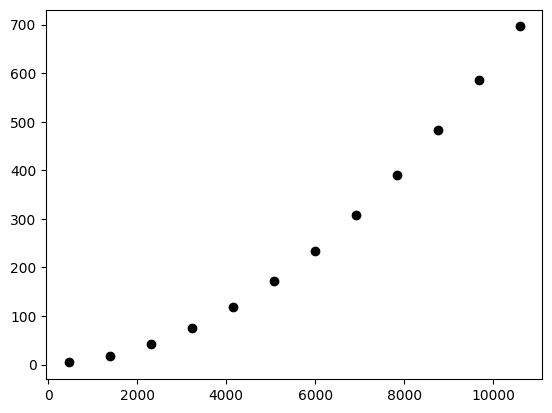

In [82]:
for i in range(len(q)):
    plt.plot(x(alp_,i,l),y(alp_,i,l), 'o', color='black')
plt.show()

In [83]:
q0

[0.5480638318746944,
 0,
 0.6128864203345292,
 0,
 0.6127437112024342,
 0,
 0.6125428124763869,
 0,
 0.6122838103067894,
 0,
 0.6119668066021792,
 0,
 0.6115919190608943,
 0,
 0.6111592811583786,
 0,
 0.6106690421502383,
 0,
 0.6101213670880773,
 0,
 0.6095164365910363,
 0,
 0.3044021490004553,
 0]

In [84]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, [q])))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, [q])))

add6=functools.partial(g,alp=alp_)
add6__g =np.array(list(map(add6, [q])))

print(datetime.now() - startTime)

0:00:00.001723


In [85]:
tmp__1 = pinv(add1__Jv.transpose(0, 2, 1))
tmp__2 = add5__f + add6__g

In [86]:
tmp__ = np.matmul(tmp__1, tmp__2)

In [87]:
dim1 = int(max_t/dt)
dim2 = dim1-1

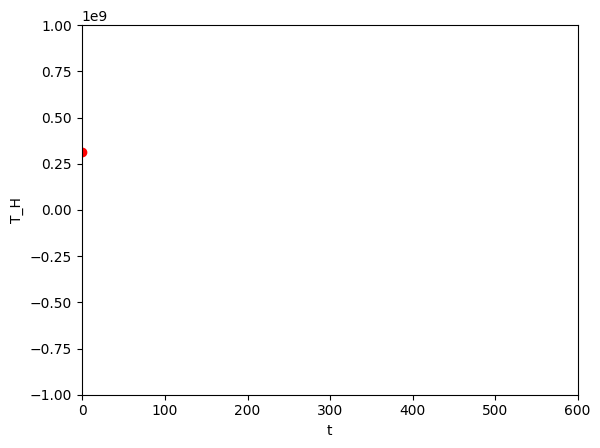

In [88]:
plt.plot(t[:len(tmp__)],tmp__[:,0],'o', color='red')
plt.xlim([-1, dim1//2])
plt.ylim([-1000000000, 1000000000])
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

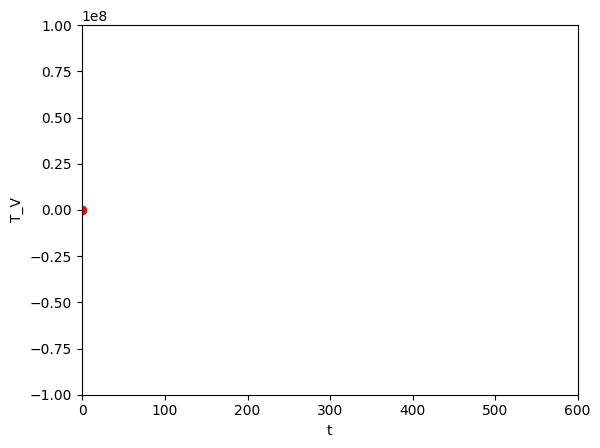

In [89]:
plt.plot(t[:len(tmp__)],tmp__[:,1],'o', color='red')
plt.xlim([-1, dim1//2])
plt.ylim([-100000000, 100000000])
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [90]:
max(tmp__[:,0]), max(tmp__[:,1])

(array([3.12468611e+08]), array([0.00019127]))

### Dynamic solution 

In [91]:
def dynamic_func(Q, t, q):
 
    q, dq = Q[0::2], Q[1::2]
    QI = q.reshape(len(q),1)
    dQ = dq.reshape(len(q),1)
    
    QI = QI.flatten().tolist()
 
    alp = alpha(QI)

    if t > DP_start:
        F = np.array([-Fx(QI, alp, dQ, kp, kd, x_ref = 0),0]).reshape(2,1)
    else:
        F = np.array([Fx_,0]).reshape(2,1)
   
    
    ddq = np.linalg.lstsq(M(QI, l, mn, In, mi), 
                        - np.dot(H(alp,QI,dQ,l), np.radians(dQ)).reshape(len(QI),1)
                        - np.dot(C(QI,dQ, l, mn, In, mi), np.radians(dQ)).reshape(len(QI),1)  
                        - f(QI, K) 
                        - g(QI,alp)
                        + tau(QI,alp, tau_qn, F, tau_q_wave), rcond=None)[0].flatten()
      
    
    ans=np.array([dq , ddq]).T.flatten()
        
    return ans

In [92]:
q

[0.5480638318746944,
 0.6128864203345292,
 0.6127437112024342,
 0.6125428124763869,
 0.6122838103067894,
 0.6119668066021792,
 0.6115919190608943,
 0.6111592811583786,
 0.6106690421502383,
 0.6101213670880773,
 0.6095164365910363,
 0.3044021490004553]

In [93]:
startTime1 = datetime.now()
us=odeint(dynamic_func, q0, t, args=(q,))
print(datetime.now() - startTime1)

0:42:00.991671


In [94]:
us_=us

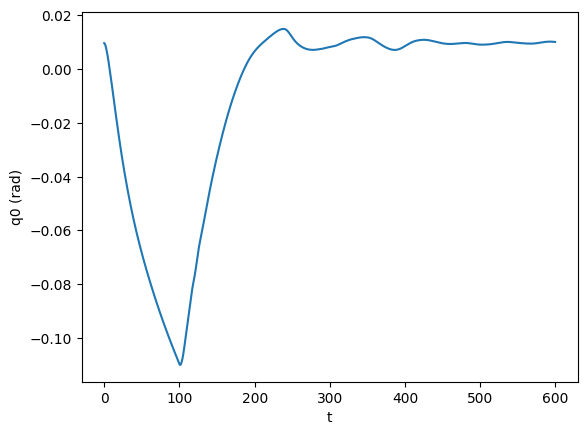

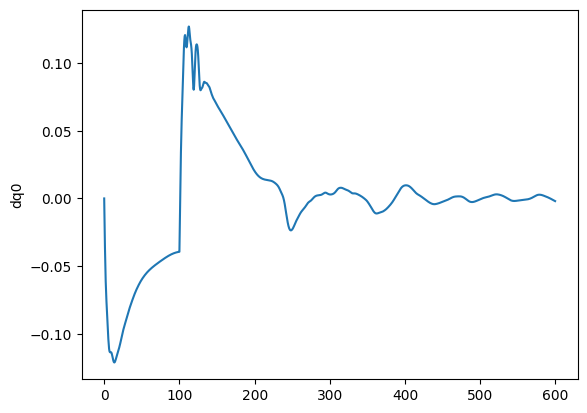

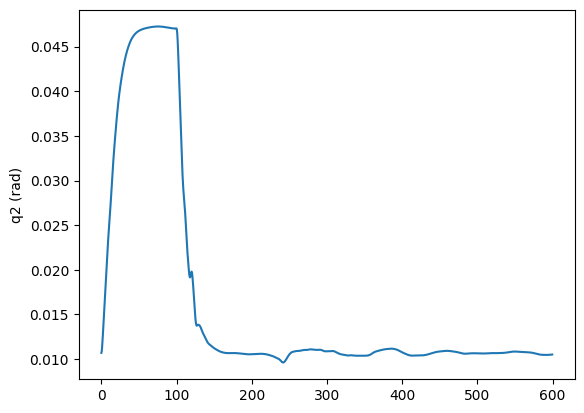

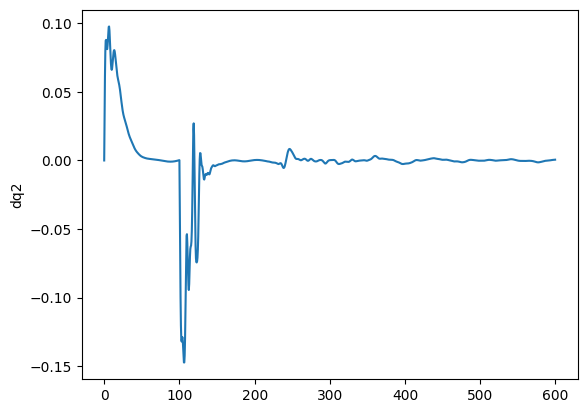

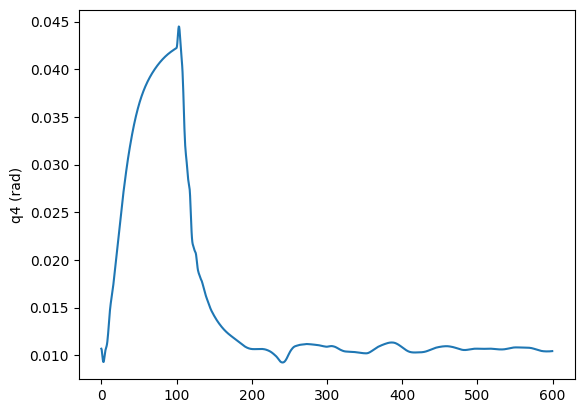

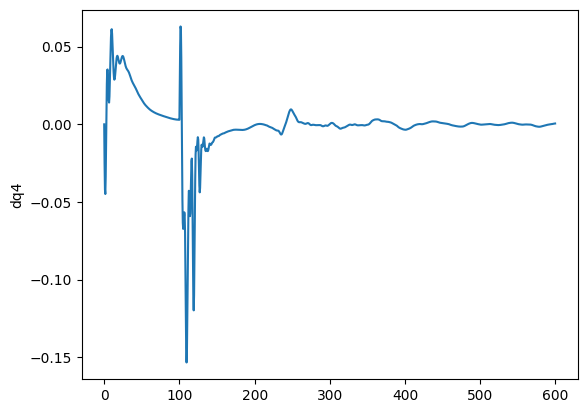

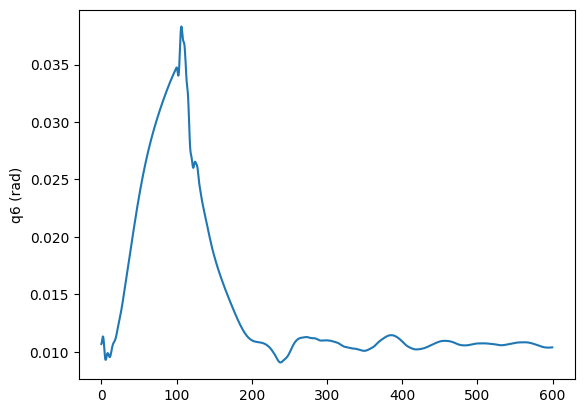

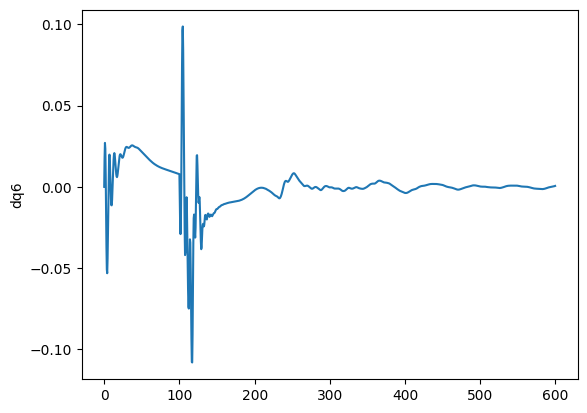

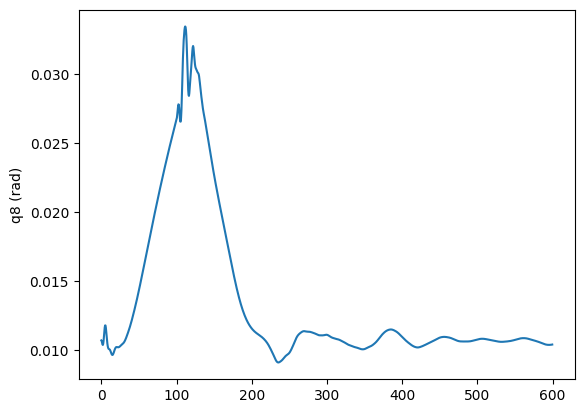

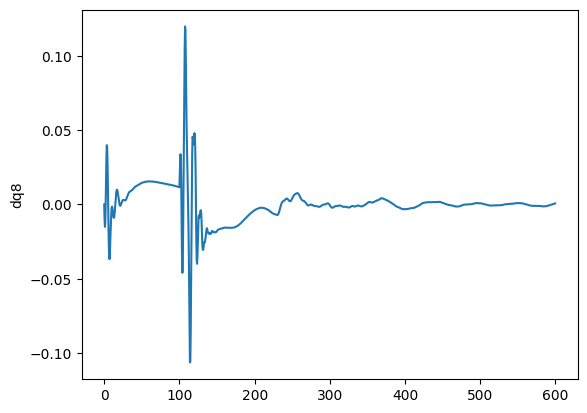

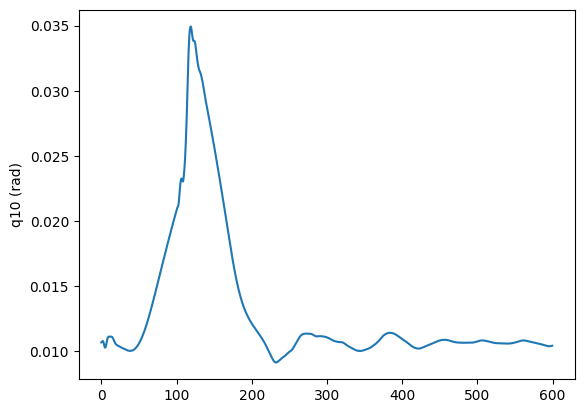

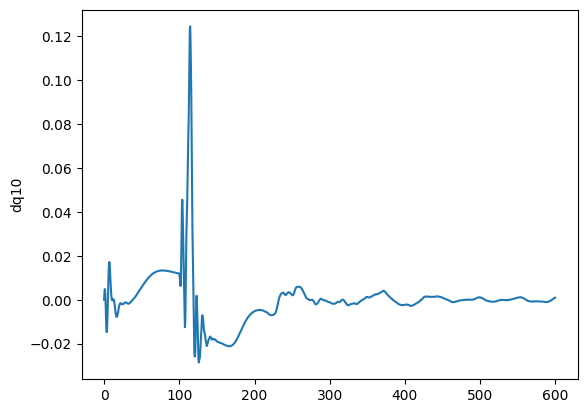

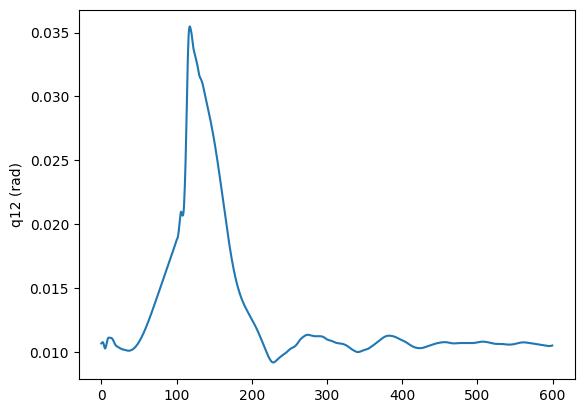

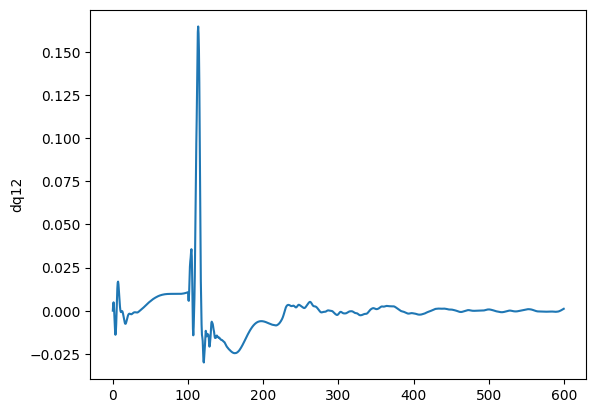

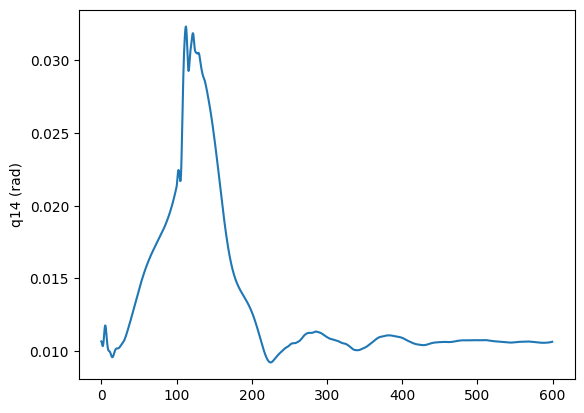

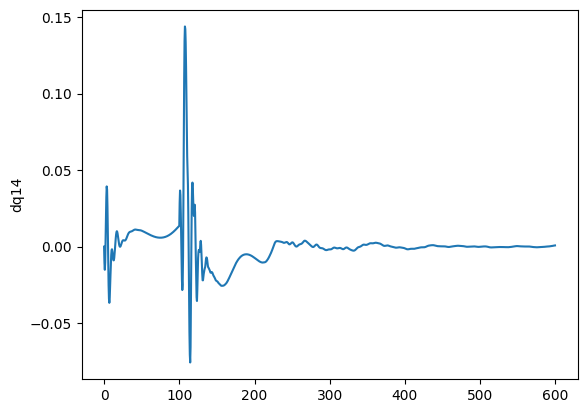

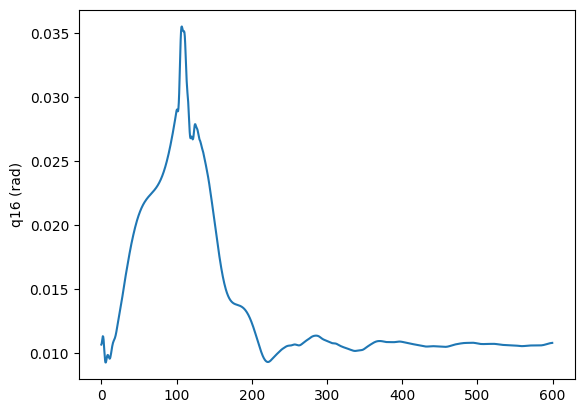

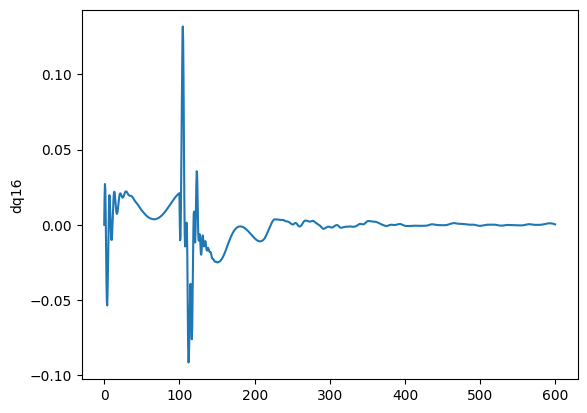

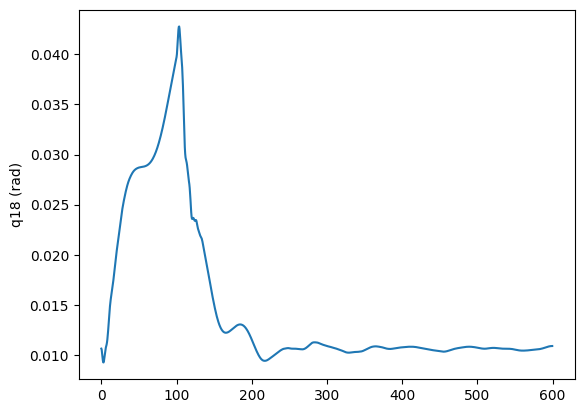

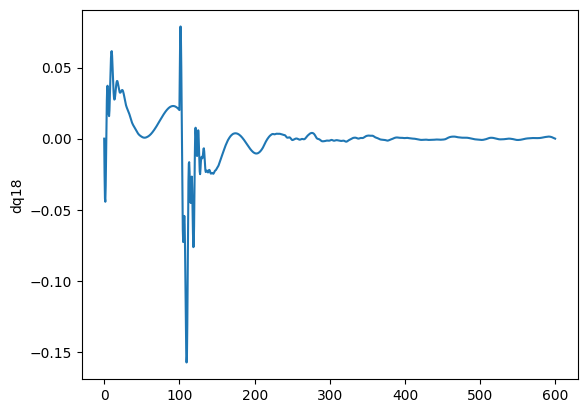

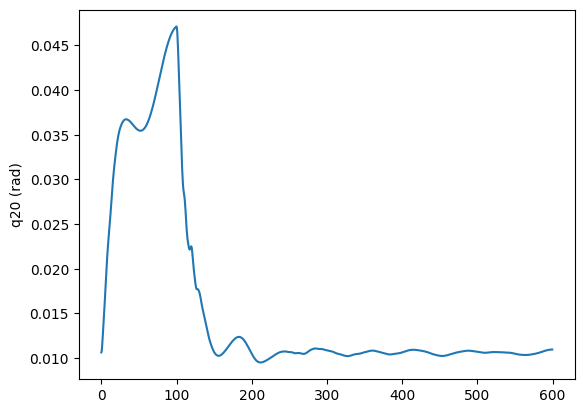

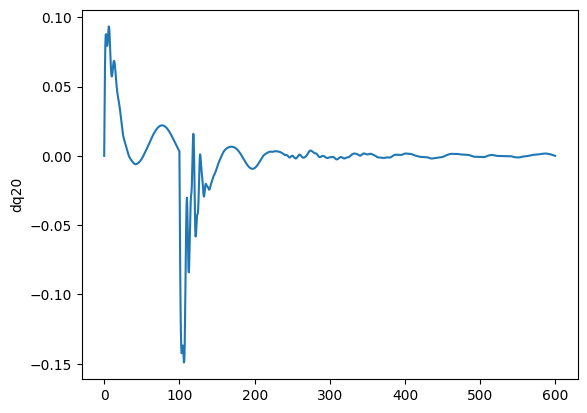

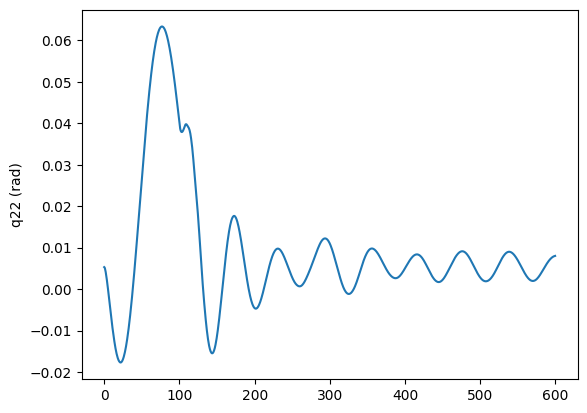

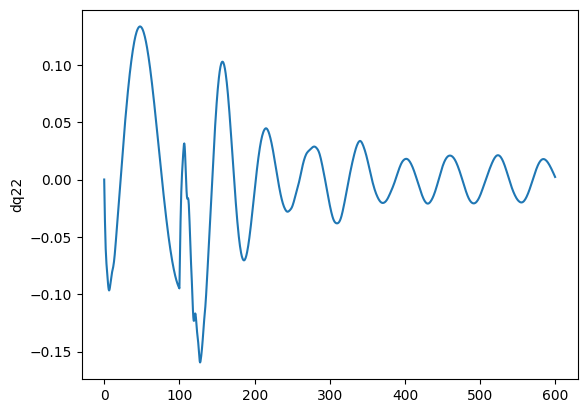

In [95]:
plt.xlabel('t')
for i in range(len(q0)):
    if i%2==0:
        plt.plot(t,np.radians(us_[:,i]) ,'-')
        plt.ylabel('q{} (rad)'.format(i))
    else:
        plt.plot(t, us_[:,i],'-')
        plt.ylabel('{}q{}'.format('d',i-1))
    plt.show()        

In [96]:
horizon_start=30

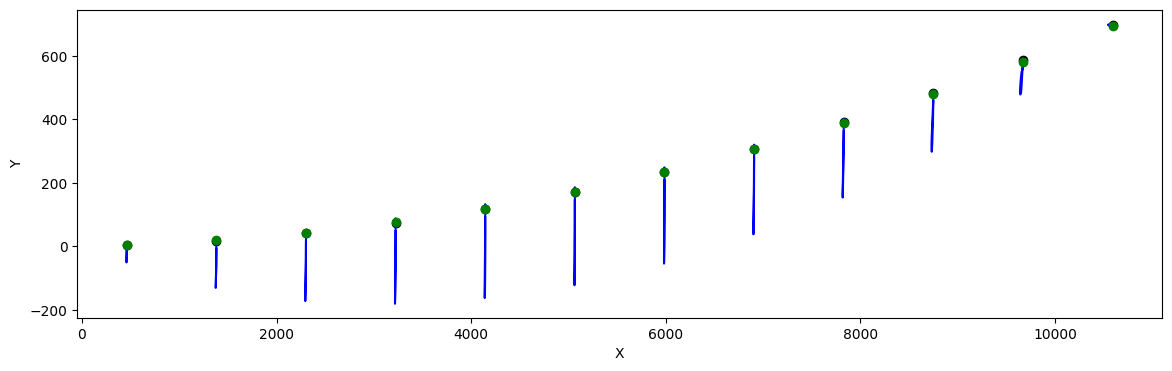

In [97]:
plt.figure(figsize=(14,4))
plt.xlabel('X')
plt.ylabel('Y')

for j in range(len(q)):
    X=[x(alpha(us_[i,[k for k in range(0,len(q0),2)]]),j,l) for i in range(horizon_start, len(us_))]
    Y=[y(alpha(us_[i,[k for k in range(0,len(q0),2)]]),j,l) for i in range(horizon_start, len(us_))]
    X_=[x(alpha(us_[i,[k for k in range(0,len(q0),2)]]),j,l) for i in range(1)]
    Y_=[y(alpha(us_[i,[k for k in range(0,len(q0),2)]]),j,l) for i in range(1)]
    plt.plot(X_,Y_, 'o', color='black')
    
    # dynamic
    plt.plot(X,Y,'b')   
    
    plt.plot(x(alpha(us_[-1,[k for k in range(0,len(q0),2)]]),j,l),
             y(alpha(us_[-1,[k for k in range(0,len(q0),2)]]),j,l), 'o', color='green')
plt.show()

### Pipe-tip tension

In [98]:
coordinates=us[:,[k for k in range(0,len(q0),2)]]
velocities=us[:,[k for k in range(0,len(q0),2)]]

In [99]:
alp_=[]
for i in range(len(us)):
    alp_.append(alpha(coordinates[i]))
alp_=np.matrix(alp_)    

In [100]:
velocities.shape

(1200, 12)

In [101]:
velocities_0=velocities[:-1]
velocities_1=velocities[1:]

In [102]:
coordinates.shape, velocities.shape

((1200, 12), (1200, 12))

In [103]:
startTime1 = datetime.now()

add4=functools.partial(C, l=l, mn=mn, In=In, mi=mi)
add4__C =np.array(list(map(add4, coordinates, velocities)))

print(datetime.now() - startTime1)

0:04:13.886482


In [104]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, coordinates)))

add2=functools.partial(M, l=l, mn=mn, In=In, mi=mi)
add2__M =np.array(list(map(add2, coordinates)))

add3=functools.partial(H,  l=l)
add3__H =np.array(list(map(add3, alp_.tolist(), coordinates, velocities)))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, coordinates)))

add6=functools.partial(g)
add6__g =np.array(list(map(add6, coordinates, alp_.tolist())))

print(datetime.now() - startTime)

0:00:03.355698


In [105]:
velocities_1.shape

(1199, 12)

In [106]:
add5__f.shape

(1200, 12, 1)

In [107]:
add6__g.shape

(1200, 12, 1)

In [108]:
add3__H.shape

(1200, 12, 12)

In [109]:
tmp__1 = pinv(add1__Jv[:-1].transpose(0, 2, 1))
tmp__2 = np.matmul(add2__M[:-1], ((np.radians(velocities_1).reshape(dim2,len(q),1) - 
                              np.radians(velocities_0).reshape(dim2,len(q),1))/dt))\
            + np.matmul(add3__H[:-1], np.radians(velocities[:-1]).reshape(dim2,len(q),1)) \
            + np.matmul(add4__C[:-1], np.radians(velocities[:-1]).reshape(dim2,len(q),1)) \
            + add5__f[:-1] \
            + add6__g[:-1]

In [110]:
tmp__=np.matmul(tmp__1, tmp__2)

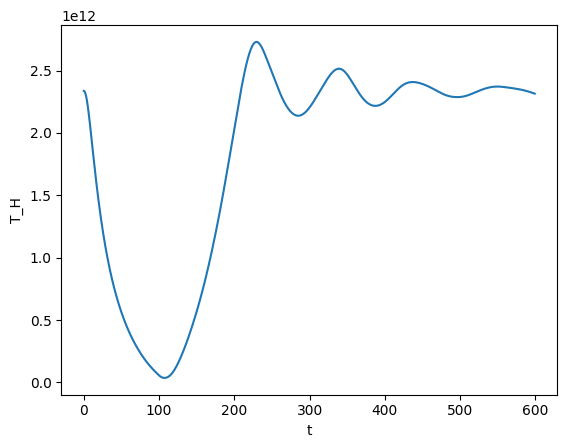

In [111]:
plt.plot(t[:len(tmp__)],tmp__[:,0],'-')
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

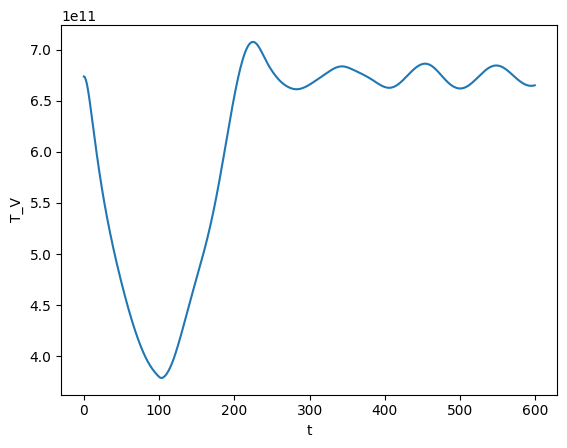

In [112]:
plt.plot(t[:len(tmp__)],tmp__[:,1],'-')
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [113]:
max(tmp__[:,0]), max(tmp__[:,1])

(array([2.72946052e+12]), array([7.07661323e+11]))

In [114]:
min(tmp__[:,0]), min(tmp__[:,1])

(array([3.53108294e+10]), array([3.78614961e+11]))